In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import warnings

In [2]:
warnings.filterwarnings('ignore')


In [3]:
# Загрузка данных
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv') # Укажите свой путь к файлу

# 1. Разведочный анализ данных (EDA)
print("=== Первый взгляд на данные ===")
print(df.info())
print("\n=== Статистика по числовым признакам ===")
print(df.describe())
print("\n=== Проверка на пропуски ===")
print(df.isnull().sum())

# Целевая переменная 'Churn' - переведем в бинарный вид 1/0
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

=== Первый взгляд на данные ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessB

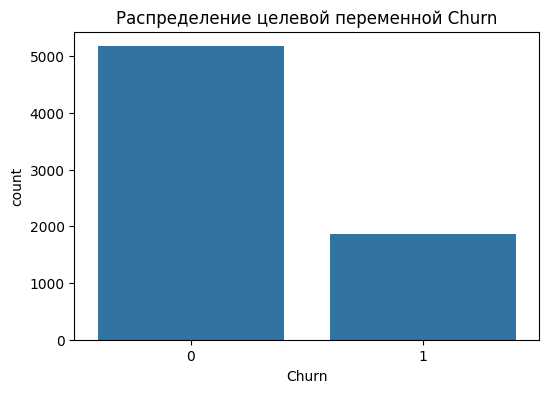

Процент оттока клиентов: 26.54%


In [4]:
# Анализ целевой переменной
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df)
plt.title('Распределение целевой переменной Churn')
plt.show()
churn_rate = df['Churn'].value_counts(normalize=True)
print(f"Процент оттока клиентов: {churn_rate[1]:.2%}")


In [5]:
# Обнаружена проблема: столбец TotalCharges имеет тип object, хотя должен быть числовым. Есть пустые строки.
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print(f"Найдено пропусков в TotalCharges после конвертации: {df['TotalCharges'].isnull().sum()}")

# Заполним пропуски в TotalCharges медианным значением
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


Найдено пропусков в TotalCharges после конвертации: 11


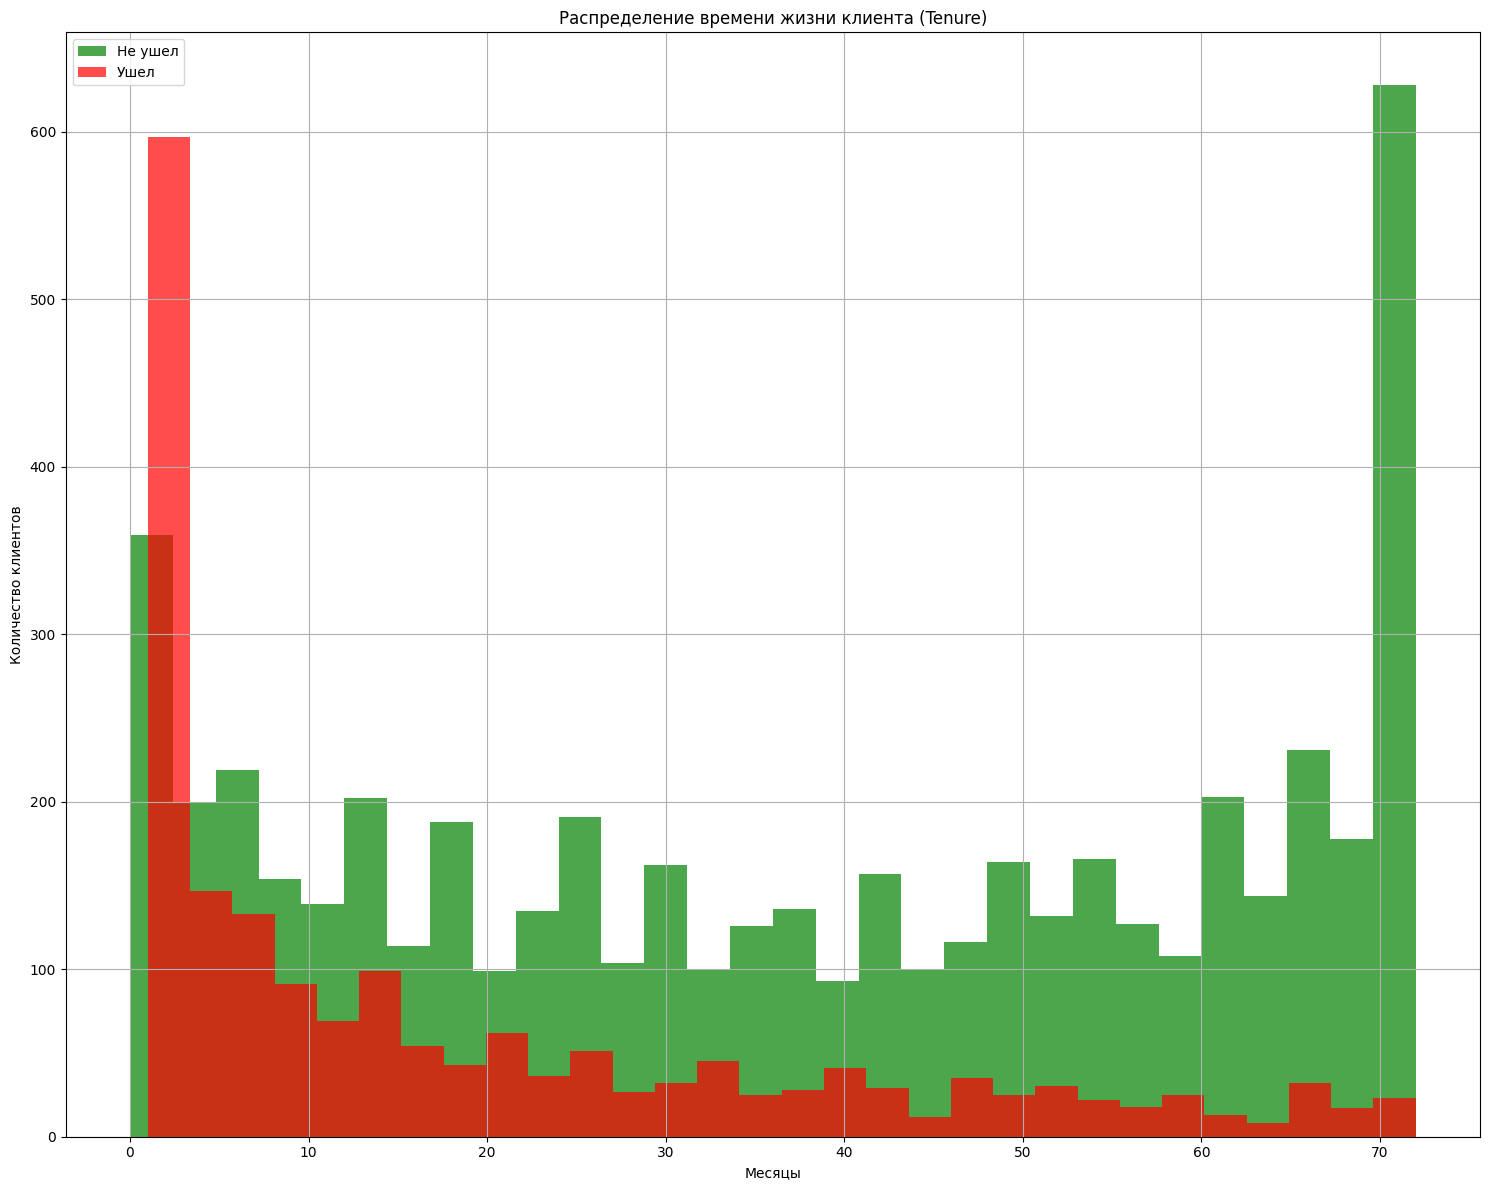

In [19]:
# Визуализация распределений - альтернативный вариант
fig, axes = plt.subplots(figsize=(15, 12))

# tenure - отдельные гистограммы для каждой группы
df[df['Churn'] == 0]['tenure'].hist(bins=30, alpha=0.7, label='Не ушел', color='green')
df[df['Churn'] == 1]['tenure'].hist(bins=30, alpha=0.7, label='Ушел', color='red')
plt.title('Распределение времени жизни клиента (Tenure)')
plt.xlabel('Месяцы')
plt.ylabel('Количество клиентов')
plt.legend()


plt.tight_layout()
plt.show()

In [7]:
# 2. Предобработка данных и feature engineering
# Удалим неинформативный столбец customerID
df.drop('customerID', axis=1, inplace=True)

# Разделим признаки на категориальные и числовые
categorical_columns = df.select_dtypes(include=['object']).columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
numerical_columns = numerical_columns.drop('Churn') # Исключаем целевую переменную

print(f"Категориальные признаки: {list(categorical_columns)}")
print(f"Числовые признаки: {list(numerical_columns)}")


Категориальные признаки: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Числовые признаки: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [8]:
# Кодируем категориальные признаки с помощью One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Разделяем данные на обучающую и тестовую выборки
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Масштабируем числовые признаки (важно для некоторых моделей, например, SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [47]:
# 3. Построение и оценка моделей
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'Support Vector Machine': SVC(probability=True, random_state=42) # probability=True для ROC-AUC
}

results = {}

for model_name, model in models.items():
    print(f"\n Обучение модели: {model_name}")
    
    # Для SVM используем масштабированные данные, для остальных - нет (Random Forest не требует)
    if model_name == 'Support Vector Machine':
        X_tr = X_train_scaled
        X_te = X_test_scaled
    else:
        X_tr = X_train
        X_te = X_test
        
    # Кросс-валидация
    cv_scores = cross_val_score(model, X_tr, y_train, cv=5, scoring='roc_auc')
    print(f"ROC-AUC на кросс-валидации: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    # Обучение и предсказание на тесте
    model.fit(X_tr, y_train)
    y_pred_proba = model.predict_proba(X_te)[:, 1]
    y_pred = model.predict(X_te)
    
    # Сохраняем результаты
    results[model_name] = {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'cv_auc_mean': cv_scores.mean(),
        'test_auc': roc_auc_score(y_test, y_pred_proba)
    }
    
    # Вывод метрик
    print(f"ROC-AUC на тестовой выборке: {results[model_name]['test_auc']:.4f}")
    print("\nОтчет по классификации:")
    print(classification_report(y_test, y_pred))


 Обучение модели: Logistic Regression
ROC-AUC на кросс-валидации: 0.8440 (+/- 0.0223)
ROC-AUC на тестовой выборке: 0.8433

Отчет по классификации:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1552
           1       0.66      0.57      0.61       561

    accuracy                           0.81      2113
   macro avg       0.76      0.73      0.74      2113
weighted avg       0.80      0.81      0.80      2113


 Обучение модели: Random Forest
ROC-AUC на кросс-валидации: 0.8288 (+/- 0.0294)
ROC-AUC на тестовой выборке: 0.8201

Отчет по классификации:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1552
           1       0.63      0.50      0.56       561

    accuracy                           0.79      2113
   macro avg       0.73      0.70      0.71      2113
weighted avg       0.78      0.79      0.78      2113


 Обучение модели: Support Vector Machine
ROC-AUC на кро


СРАВНЕНИЕ МОДЕЛЕЙ ПО ROC-AUC:
Logistic Regression: Тестовая ROC-AUC = 0.8433
Random Forest: Тестовая ROC-AUC = 0.8201
Support Vector Machine: Тестовая ROC-AUC = 0.8062


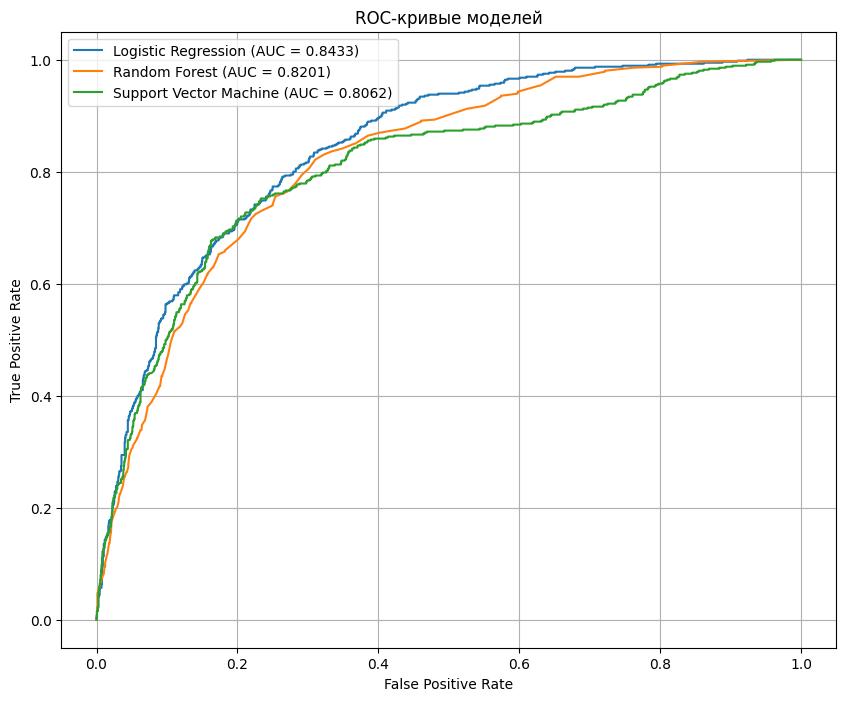

In [20]:
# 4. Сравнение моделей и выбор лучшей
print("\n" + "="*50)
print("СРАВНЕНИЕ МОДЕЛЕЙ ПО ROC-AUC:")
print("="*50)
for name, res in results.items():
    print(f"{name}: Тестовая ROC-AUC = {res['test_auc']:.4f}")

# Визуализация ROC-кривых
plt.figure(figsize=(10, 8))
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['y_pred_proba'])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {res["test_auc"]:.4f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые моделей')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# 5. Анализ важности признаков для лучшей модели (Random Forest)
best_model_name = max(results, key=lambda x: results[x]['test_auc'])
best_model = results[best_model_name]['model']

print(f"\nЛучшая модель: {best_model_name}")

if best_model_name == 'Random Forest':
    feature_importances = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(data=feature_importances.head(15), x='importance', y='feature')
    plt.title('Топ-15 самых важных признаков (Random Forest)')
    plt.tight_layout()
    plt.show()


Лучшая модель: Logistic Regression


## Проверка гипотез

In [46]:
import scipy.stats as stats
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu
import numpy as np

print("СТАТИСТИЧЕСКАЯ ПРОВЕРКА ГИПОТЕЗ")

# Создаем отдельную копию для проверки гипотез
df_hypothesis = df.copy()

# 1. ГИПОТЕЗА: Клиенты с помесячным контрактом уходят чаще
print("\n1. ГИПОТЕЗА: Клиенты с помесячным контрактом уходят чаще")
print("-" * 50)

contract_churn_table = pd.crosstab(df_hypothesis['Contract'], df_hypothesis['Churn'])
print("Таблица сопряженности:")
print(contract_churn_table)
print()

# Тест хи-квадрат
chi2, p_value, dof, expected = chi2_contingency(contract_churn_table)
print(f"Тест хи-квадрат: χ² = {chi2:.4f}, p-value = {p_value:.10f}")

# Расчет относительного риска (Relative Risk) для Month-to-month
month_to_month_churn_rate = contract_churn_table.loc['Month-to-month', 1] / contract_churn_table.loc['Month-to-month'].sum()
one_year_churn_rate = contract_churn_table.loc['One year', 1] / contract_churn_table.loc['One year'].sum()
two_year_churn_rate = contract_churn_table.loc['Two year', 1] / contract_churn_table.loc['Two year'].sum()

print(f"\nПроцент оттока по типам контракта:")
print(f"Month-to-month: {month_to_month_churn_rate:.2%}")
print(f"One year: {one_year_churn_rate:.2%}")
print(f"Two year: {two_year_churn_rate:.2%}")

print(f"\nОтносительный риск (Month-to-month vs Two year): {month_to_month_churn_rate/two_year_churn_rate:.2f}")

if p_value < 0.05:
    print("✓ ГИПОТЕЗА ПОДТВЕРЖДЕНА: Существует статистически значимая связь между типом контракта и оттоком")
else:
    print("✗ ГИПОТЕЗА ОТВЕРГНУТА: Нет статистически значимой связи")

# 2. ГИПОТЕЗА: Клиенты с оптоволоконным интернетом уходят чаще
print("\n\n2. ГИПОТЕЗА: Клиенты с оптоволоконным интернетом уходят чаще")
print("-" * 50)

internet_churn_table = pd.crosstab(df_hypothesis['InternetService'], df_hypothesis['Churn'])
print("Таблица сопряженности:")
print(internet_churn_table)
print()

chi2, p_value, dof, expected = chi2_contingency(internet_churn_table)
print(f"Тест хи-квадрат: χ² = {chi2:.4f}, p-value = {p_value:.10f}")

# Расчет процентов оттока
fiber_churn_rate = internet_churn_table.loc['Fiber optic', 1] / internet_churn_table.loc['Fiber optic'].sum()
dsl_churn_rate = internet_churn_table.loc['DSL', 1] / internet_churn_table.loc['DSL'].sum()
no_internet_churn_rate = internet_churn_table.loc['No', 1] / internet_churn_table.loc['No'].sum()

print(f"\nПроцент оттока по типам интернета:")
print(f"Fiber optic: {fiber_churn_rate:.2%}")
print(f"DSL: {dsl_churn_rate:.2%}")
print(f"No internet: {no_internet_churn_rate:.2%}")

if p_value < 0.05:
    print("✓ ГИПОТЕЗА ПОДТВЕРЖДЕНА: Существует статистически значимая связь между типом интернета и оттоком")
    if fiber_churn_rate > dsl_churn_rate and fiber_churn_rate > no_internet_churn_rate:
        print("✓ ДОПОЛНИТЕЛЬНО: Клиенты с Fiber optic действительно уходят чаще всего")
else:
    print("✗ ГИПОТЕЗА ОТВЕРГНУТА: Нет статистически значимой связи")

# 3. ГИПОТЕЗА: Время жизни клиента (tenure) влияет на отток
print("\n\n3. ГИПОТЕЗА: Время жизни клиента (tenure) влияет на отток")
print("-" * 50)

# Разделяем на две группы
tenure_stayed = df_hypothesis[df_hypothesis['Churn'] == 0]['tenure']
tenure_churned = df_hypothesis[df_hypothesis['Churn'] == 1]['tenure']

print(f"Среднее время жизни:")
print(f"Не ушли: {tenure_stayed.mean():.2f} месяцев")
print(f"Ушли: {tenure_churned.mean():.2f} месяцев")
print(f"Медиана:")
print(f"Не ушли: {tenure_stayed.median():.2f} месяцев")
print(f"Ушли: {tenure_churned.median():.2f} месяцев")

# T-тест для независимых выборок
t_stat, p_value = ttest_ind(tenure_stayed, tenure_churned, equal_var=False)
print(f"\nT-тест: t = {t_stat:.4f}, p-value = {p_value:.10f}")

# Непараметрический тест Манна-Уитни (более надежный для ненормальных распределений)
u_stat, p_value_mw = mannwhitneyu(tenure_stayed, tenure_churned)
print(f"U-тест Манна-Уитни: U = {u_stat:.0f}, p-value = {p_value_mw:.10f}")

if p_value < 0.05:
    print("✓ ГИПОТЕЗА ПОДТВЕРЖДЕНА: Существует статистически значимая разница в времени жизни между группами")
else:
    print("✗ ГИПОТЕЗА ОТВЕРГНУТА: Нет статистически значимой разницы")

# 4. ГИПОТЕЗА: Клиенты с безбумажным биллингом уходят чаще
print("\n\n4. ГИПОТЕЗА: Клиенты с безбумажным биллингом уходят чаще")
print("-" * 50)

paperless_churn_table = pd.crosstab(df_hypothesis['PaperlessBilling'], df_hypothesis['Churn'])
print("Таблица сопряженности:")
print(paperless_churn_table)
print()

chi2, p_value, dof, expected = chi2_contingency(paperless_churn_table)
print(f"Тест хи-квадрат: χ² = {chi2:.4f}, p-value = {p_value:.10f}")

paperless_yes_rate = paperless_churn_table.loc['Yes', 1] / paperless_churn_table.loc['Yes'].sum()
paperless_no_rate = paperless_churn_table.loc['No', 1] / paperless_churn_table.loc['No'].sum()

print(f"\nПроцент оттока:")
print(f"Paperless Billing (Yes): {paperless_yes_rate:.2%}")
print(f"Paperless Billing (No): {paperless_no_rate:.2%}")

if p_value < 0.05:
    print("✓ ГИПОТЕЗА ПОДТВЕРЖДЕНА: Существует статистически значимая связь")
    if paperless_yes_rate > paperless_no_rate:
        print("✓ ДОПОЛНИТЕЛЬНО: Клиенты с безбумажным биллингом действительно уходят чаще")
else:
    print("✗ ГИПОТЕЗА ОТВЕРГНУТА: Нет статистически значимой связи")

# 5. ГИПОТЕЗА: Способ оплаты влияет на отток
print("\n\n5. ГИПОТЕЗА: Способ оплаты влияет на отток")
print("-" * 50)

payment_churn_table = pd.crosstab(df_hypothesis['PaymentMethod'], df_hypothesis['Churn'])
print("Таблица сопряженности:")
print(payment_churn_table)
print()

chi2, p_value, dof, expected = chi2_contingency(payment_churn_table)
print(f"Тест хи-квадрат: χ² = {chi2:.4f}, p-value = {p_value:.10f}")

print("\nПроцент оттока по способам оплаты:")
for method in payment_churn_table.index:
    churn_rate = payment_churn_table.loc[method, 1] / payment_churn_table.loc[method].sum()
    print(f"{method}: {churn_rate:.2%}")

if p_value < 0.05:
    print("✓ ГИПОТЕЗА ПОДТВЕРЖДЕНА: Существует статистически значимая связь между способом оплаты и оттоком")
else:
    print("✗ ГИПОТЕЗА ОТВЕРГНУТА: Нет статистически значимой связи")

# 6. ГИПОТЕЗА: Ежемесячные траты влияют на отток
print("\n\n6. ГИПОТЕЗА: Ежемесячные траты влияют на отток")
print("-" * 50)

charges_stayed = df_hypothesis[df_hypothesis['Churn'] == 0]['MonthlyCharges']
charges_churned = df_hypothesis[df_hypothesis['Churn'] == 1]['MonthlyCharges']

print(f"Средние ежемесячные траты:")
print(f"Не ушли: ${charges_stayed.mean():.2f}")
print(f"Ушли: ${charges_churned.mean():.2f}")

t_stat, p_value = ttest_ind(charges_stayed, charges_churned, equal_var=False)
print(f"\nT-тест: t = {t_stat:.4f}, p-value = {p_value:.10f}")

u_stat, p_value_mw = mannwhitneyu(charges_stayed, charges_churned)
print(f"U-тест Манна-Уитни: U = {u_stat:.0f}, p-value = {p_value_mw:.10f}")

# Дополнительно: Коэффициент корреляции
correlation, p_corr = stats.pearsonr(df_hypothesis['MonthlyCharges'], df_hypothesis['Churn'])
print(f"Коэффициент корреляции Пирсона: r = {correlation:.4f}, p-value = {p_corr:.10f}")

if p_value < 0.05:
    print("✓ ГИПОТЕЗА ПОДТВЕРЖДЕНА: Существует статистически значимая разница в ежемесячных тратах")
else:
    print("✗ ГИПОТЕЗА ОТВЕРГНУТА: Нет статистически значимой разницы")

# 7. ГИПОТЕЗА: Техподдержка влияет на отток
print("\n\n7. ГИПОТЕЗА: Техподдержка влияет на отток")
print("-" * 50)

techsupport_churn_table = pd.crosstab(df_hypothesis['TechSupport'], df_hypothesis['Churn'])
print("Таблица сопряженности:")
print(techsupport_churn_table)
print()

chi2, p_value, dof, expected = chi2_contingency(techsupport_churn_table)
print(f"Тест хи-квадрат: χ² = {chi2:.4f}, p-value = {p_value:.10f}")

techsupport_yes_rate = techsupport_churn_table.loc['Yes', 1] / techsupport_churn_table.loc['Yes'].sum()
techsupport_no_rate = techsupport_churn_table.loc['No', 1] / techsupport_churn_table.loc['No'].sum()

print(f"\nПроцент оттока по наличию техподдержки:")
print(f"Tech Support (Yes): {techsupport_yes_rate:.2%}")
print(f"Tech Support (No): {techsupport_no_rate:.2%}")

# Расчет эффекта размера (разница рисков)
risk_difference = techsupport_no_rate - techsupport_yes_rate
relative_risk = techsupport_no_rate / techsupport_yes_rate
print(f"Разница рисков: {risk_difference:.3f}")
print(f"Относительный риск: {relative_risk:.2f}")

if p_value < 0.05:
    print("✓ ГИПОТЕЗА ПОДТВЕРЖДЕНА: Существует статистически значимая связь между техподдержкой и оттоком")
    if techsupport_yes_rate < techsupport_no_rate:
        print(f"✓ ДОПОЛНИТЕЛЬНО: Техподдержка снижает отток на {(risk_difference*100):.1f}%")
else:
    print("✗ ГИПОТЕЗА ОТВЕРГНУТА: Нет статистически значимой связи")

# 8. ГИПОТЕЗА: Пол клиента влияет на отток
print("\n\n8. ГИПОТЕЗА: Мужчины уходят чаще женщин")
print("-" * 50)

# Создаем таблицу сопряженности
gender_churn_table = pd.crosstab(df_hypothesis['gender'], df_hypothesis['Churn'])
print("Таблица сопряженности:")
print(gender_churn_table)
print()

# Тест хи-квадрат
chi2, p_value, dof, expected = chi2_contingency(gender_churn_table)
print(f"Тест хи-квадрат: χ² = {chi2:.4f}, p-value = {p_value:.10f}")

# Расчет процентов оттока
male_churn = df_hypothesis[df_hypothesis['gender'] == 'Male']['Churn'].mean()
female_churn = df_hypothesis[df_hypothesis['gender'] == 'Female']['Churn'].mean()

print(f"\nПроцент оттока по полу:")
print(f"Мужчины (Male): {male_churn:.2%}")
print(f"Женщины (Female): {female_churn:.2%}")
print(f"Абсолютная разница: {abs(male_churn - female_churn):.2%}")

if p_value < 0.05:
    print("✓ ГИПОТЕЗА ПОДТВЕРЖДЕНА: Существует статистически значимая связь между полом клиента и оттоком")
    if male_churn > female_churn:
        print("✓ ДОПОЛНИТЕЛЬНО: Мужчины действительно уходят чаще женщин")
    else:
        print("✓ ДОПОЛНИТЕЛЬНО: Женщины уходят чаще мужчин (противоположно гипотезе)")
else:
    print("✗ ГИПОТЕЗА НЕ ПОДТВЕРЖДЕНА: Нет статистически значимой связи между полом клиента и оттоком")
    print("  Разница в оттоке объясняется случайными колебаниями")


СТАТИСТИЧЕСКАЯ ПРОВЕРКА ГИПОТЕЗ

1. ГИПОТЕЗА: Клиенты с помесячным контрактом уходят чаще
--------------------------------------------------
Таблица сопряженности:
Churn              0     1
Contract                  
Month-to-month  2220  1655
One year        1307   166
Two year        1647    48

Тест хи-квадрат: χ² = 1184.5966, p-value = 0.0000000000

Процент оттока по типам контракта:
Month-to-month: 42.71%
One year: 11.27%
Two year: 2.83%

Относительный риск (Month-to-month vs Two year): 15.08
✓ ГИПОТЕЗА ПОДТВЕРЖДЕНА: Существует статистически значимая связь между типом контракта и оттоком


2. ГИПОТЕЗА: Клиенты с оптоволоконным интернетом уходят чаще
--------------------------------------------------
Таблица сопряженности:
Churn               0     1
InternetService            
DSL              1962   459
Fiber optic      1799  1297
No               1413   113

Тест хи-квадрат: χ² = 732.3096, p-value = 0.0000000000

Процент оттока по типам интернета:
Fiber optic: 41.89%
DSL: 18.96

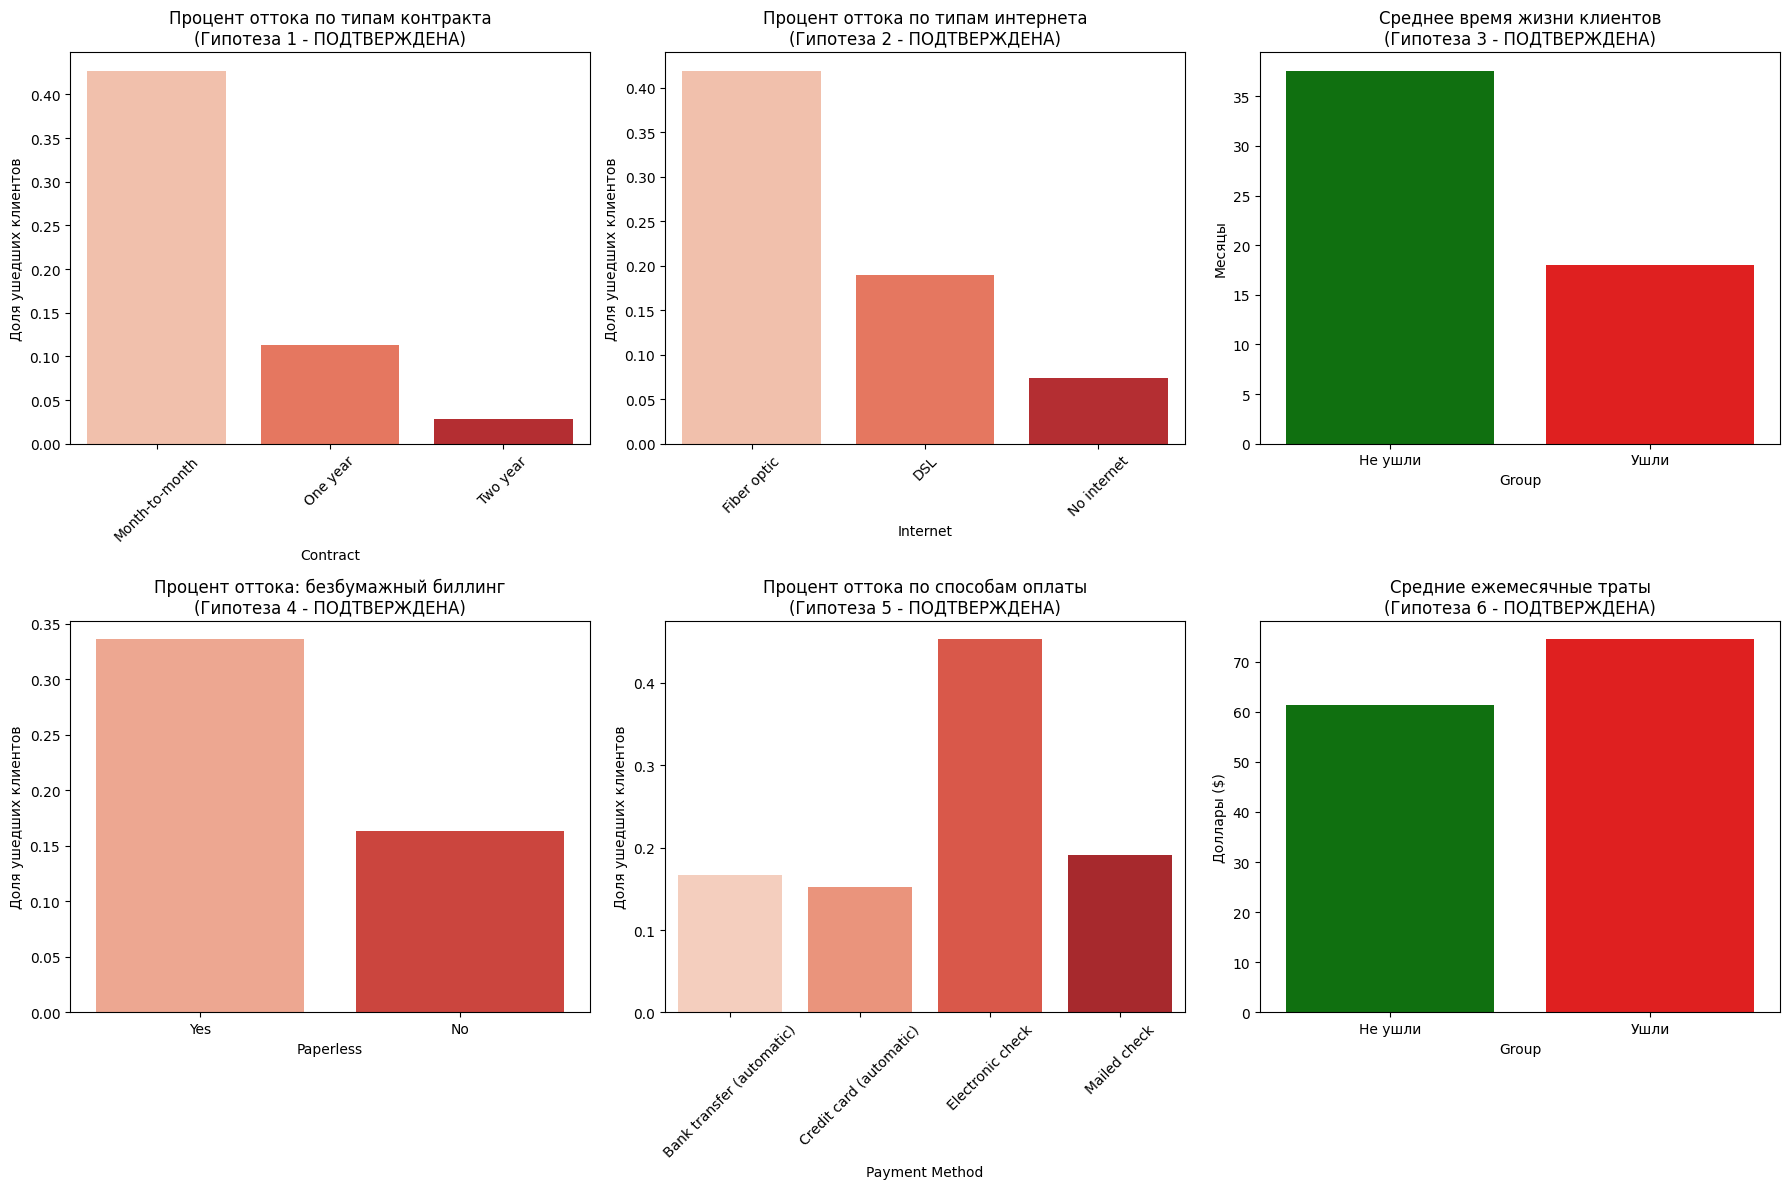

In [ ]:
# Визуализация результатов проверки гипотез
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Контракт----ы
contract_rates = pd.DataFrame({
    'Contract': ['Month-to-month', 'One year', 'Two year'],
    'Churn Rate': [month_to_month_churn_rate, one_year_churn_rate, two_year_churn_rate]
})
sns.barplot(data=contract_rates, x='Contract', y='Churn Rate', ax=axes[0,0], palette='Reds')
axes[0,0].set_title('Процент оттока по типам контракта\n(Гипотеза 1 - ПОДТВЕРЖДЕНА)')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].set_ylabel('Доля ушедших клиентов')

# 2. Интернет-услуги
internet_rates = pd.DataFrame({
    'Internet': ['Fiber optic', 'DSL', 'No internet'],
    'Churn Rate': [fiber_churn_rate, dsl_churn_rate, no_internet_churn_rate]
})
sns.barplot(data=internet_rates, x='Internet', y='Churn Rate', ax=axes[0,1], palette='Reds')
axes[0,1].set_title('Процент оттока по типам интернета\n(Гипотеза 2 - ПОДТВЕРЖДЕНА)')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].set_ylabel('Доля ушедших клиентов')

# 3. Время жизни
tenure_comparison = pd.DataFrame({
    'Group': ['Не ушли', 'Ушли'],
    'Mean Tenure': [tenure_stayed.mean(), tenure_churned.mean()]
})
sns.barplot(data=tenure_comparison, x='Group', y='Mean Tenure', ax=axes[0,2], palette=['green', 'red'])
axes[0,2].set_title('Среднее время жизни клиентов\n(Гипотеза 3 - ПОДТВЕРЖДЕНА)')
axes[0,2].set_ylabel('Месяцы')

# 4. Безбумажный биллинг
paperless_rates = pd.DataFrame({
    'Paperless': ['Yes', 'No'],
    'Churn Rate': [paperless_yes_rate, paperless_no_rate]
})
sns.barplot(data=paperless_rates, x='Paperless', y='Churn Rate', ax=axes[1,0], palette='Reds')
axes[1,0].set_title('Процент оттока: безбумажный биллинг\n(Гипотеза 4 - ПОДТВЕРЖДЕНА)')
axes[1,0].set_ylabel('Доля ушедших клиентов')

# 5. Способ оплаты
payment_rates = []
for method in payment_churn_table.index:
    rate = payment_churn_table.loc[method, 1] / payment_churn_table.loc[method].sum()
    payment_rates.append({'Payment Method': method, 'Churn Rate': rate})
payment_rates_df = pd.DataFrame(payment_rates)
sns.barplot(data=payment_rates_df, x='Payment Method', y='Churn Rate', ax=axes[1,1], palette='Reds')
axes[1,1].set_title('Процент оттока по способам оплаты\n(Гипотеза 5 - ПОДТВЕРЖДЕНА)')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].set_ylabel('Доля ушедших клиентов')

# 6. Ежемесячные траты
charges_comparison = pd.DataFrame({
    'Group': ['Не ушли', 'Ушли'],
    'Mean Charges': [charges_stayed.mean(), charges_churned.mean()]
})
sns.barplot(data=charges_comparison, x='Group', y='Mean Charges', ax=axes[1,2], palette=['green', 'red'])
axes[1,2].set_title('Средние ежемесячные траты\n(Гипотеза 6 - ПОДТВЕРЖДЕНА)')
axes[1,2].set_ylabel('Доллары ($)')

plt.tight_layout()
plt.show()


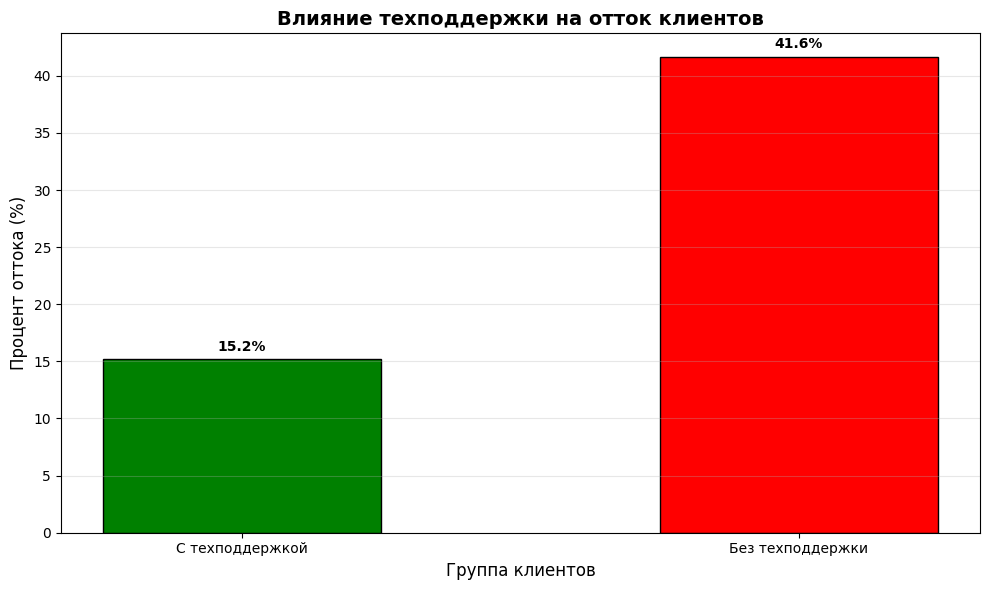

In [40]:
# Гипотеза 7: Влияние техподдержки на отток
techsupport_churn_table = pd.crosstab(df['TechSupport'], df['Churn'])

# Расчет процентов оттока
techsupport_yes_rate = techsupport_churn_table.loc['Yes', 1] / techsupport_churn_table.loc['Yes'].sum()
techsupport_no_rate = techsupport_churn_table.loc['No', 1] / techsupport_churn_table.loc['No'].sum()

# Создаем график
fig, ax = plt.subplots(figsize=(10, 6))

# Данные для визуализации
groups = ['С техподдержкой', 'Без техподдержки']
rates = [techsupport_yes_rate * 100, techsupport_no_rate * 100]
colors = ['green', 'red']

# Строим гистограмму
bars = ax.bar(groups, rates, color=colors, edgecolor='black', width=0.5)

# Настройки графика
ax.set_title('Влияние техподдержки на отток клиентов', fontsize=14, fontweight='bold')
ax.set_ylabel('Процент оттока (%)', fontsize=12)
ax.set_xlabel('Группа клиентов', fontsize=12)
ax.grid(axis='y', alpha=0.3)

# Добавляем значения на столбцы
for bar, rate in zip(bars, rates):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')


plt.tight_layout()
plt.show()

ГИПОТЕЗА 8: Мужчины уходят чаще женщин
Отток мужчин: 26.2%
Отток женщин: 26.9%
Разница: 0.8%

ГИПОТЕЗА НЕ ПОДТВЕРЖДЕНА
Нет значимой разницы в оттоке между мужчинами и женщинами


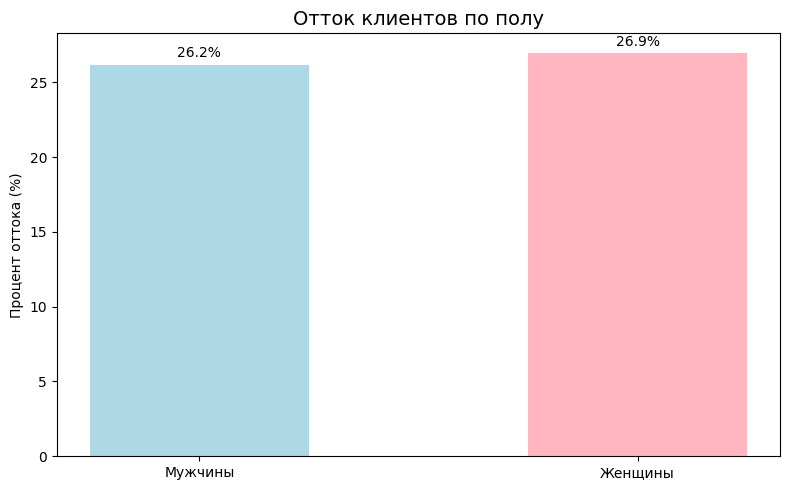


Вывод: Пол клиента не влияет на отток


In [39]:
# Гипотеза 8: Влияние пола на отток клиентов
print("ГИПОТЕЗА 8: Мужчины уходят чаще женщин")

# Считаем отток по полу
male_churn = df[df['gender'] == 'Male']['Churn'].mean()
female_churn = df[df['gender'] == 'Female']['Churn'].mean()

print(f"Отток мужчин: {male_churn:.1%}")
print(f"Отток женщин: {female_churn:.1%}")
print(f"Разница: {abs(male_churn - female_churn):.1%}")

# Простая проверка
if abs(male_churn - female_churn) < 0.02:  # меньше 2% разницы
    print("\nГИПОТЕЗА НЕ ПОДТВЕРЖДЕНА")
    print("Нет значимой разницы в оттоке между мужчинами и женщинами")
else:
    print("\nГИПОТЕЗА ПОДТВЕРЖДЕНА")

# Простая визуализация
fig, ax = plt.subplots(figsize=(8, 5))

groups = ['Мужчины', 'Женщины']
rates = [male_churn * 100, female_churn * 100]

bars = ax.bar(groups, rates, color=['lightblue', 'lightpink'], width=0.5)

ax.set_title('Отток клиентов по полу', fontsize=14)
ax.set_ylabel('Процент оттока (%)')

# Цифры на столбцах
for bar, rate in zip(bars, rates):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.5, 
            f'{rate:.1f}%', ha='center')

plt.tight_layout()
plt.show()

print("\nВывод: Пол клиента не влияет на отток")